Prepare Data for training

In [1]:
import os
import requests
import pandas as pd
from pandas import json_normalize
from decouple import config
from dotenv import load_dotenv
load_dotenv()
                                                        
# url = os.environ.get("EXTERNAL_URL") + '/events'
url = "http://localhost:8080/users/user-preference/list"
payload={}
headers={}

response=requests.request("GET",url,headers=headers,data=payload)

users=json_normalize(response.json())

data_users=users.iloc[0]

users_df = pd.DataFrame(data_users)

# df_transposed = users_df.transpose()
new_data = []
for i in range(len(users_df[0]['userId'])):
    userId = users_df[0]['userId'][i]
    categories = users_df[0]['categories'][i]

    new_data.append({
        "userId": userId,
        "categories": categories
    })

new_df = pd.DataFrame(new_data)

# print(new_df)
new_df.head()

,userId,categories
0,31de82ba-c5db-4c0a-9f77-61b6b7f7c92e,[8]
1,48a18dd9-48c3-45a5-b4f3-e8d7a60e2910,[8]


In [2]:
url = "http://localhost:8080/users/event-preference/list"
payload={}
headers={}

response=requests.request("GET",url,headers=headers,data=payload)

events=json_normalize(response.json())

data_eventss=events.iloc[0]

events_df = pd.DataFrame(data_eventss)

new_events_data = []
for i in range(len(events_df[0]['id'])):
    Id = events_df[0]['id'][i]
    name = events_df[0]['name'][i]
    categories = events_df[0]['categories'][i]

    new_events_data.append({
        "id": Id,
        "name": name,
        "categories": categories
    })

events_train_df = pd.DataFrame(new_events_data)

# print(new_df)
events_train_df.head()

,id,name,categories
0,24,CampusWithCMU (UPDATED!!!),"[5, 11, 12, 13]"


category in the system

In [ ]:
url_cat=os.environ.get("EXTERNAL_URL") + '/events/categories/list'
payload_cat={}
headers_cat={}

response_cat=requests.request("GET", url_cat ,headers=headers_cat, data=payload_cat)
df_cat=json_normalize(response_cat.json())

categories = []
for i in range(len(df_cat['categories'][0])):
    # print(df_cat['categories'][0][i]['label'])
    categories.append(df_cat['categories'][0][i]['label'])

# print(categories)
cat = categories[2:]
print(cat)

['incubation', 'networking', 'forum', 'exhibition', 'competition', 'workshop', 'campaign', 'esg', 'environment', 'social', 'governance']


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# users_df = pd.DataFrame(data_users)
# events_df = pd.DataFrame(data_events)

users_df = new_df
events_df = events_train_df

user_map = {uid: idx for idx, uid in enumerate(users_df["userId"])}
event_map = {eid: idx for idx, eid in enumerate(events_df["id"])}

num_users = len(user_map)
num_events = len(event_map)
embedding_dim = 16  # Size of the latent space

# Create Interaction Matrix (Random)
interaction_matrix = torch.rand((num_users, num_events))

class NCFModel(nn.Module):
    def __init__(self, num_users, num_events, embedding_dim):
        super(NCFModel, self).__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.event_emb = nn.Embedding(num_events, embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, user_ids, event_ids):
        user_vecs = self.user_emb(user_ids)
        event_vecs = self.event_emb(event_ids)
        x = torch.cat([user_vecs, event_vecs], dim=1)
        return self.mlp(x).squeeze(1)
        # return (user_vecs * event_vecs).sum(1)  # Dot product

# Initialize Model
model = NCFModel(num_users, num_events, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Prepare Training Data
# user_ids = torch.tensor([user_map[uid] for uid in users_df["userId"]], dtype=torch.long)
# event_ids = torch.tensor([event_map[eid] for eid in events_df["id"]], dtype=torch.long)
# targets = interaction_matrix[user_ids, event_ids]

user_ids, event_ids = torch.meshgrid(
    torch.arange(num_users), torch.arange(num_events), indexing="ij"
)
user_ids, event_ids = user_ids.flatten(), event_ids.flatten()
targets = interaction_matrix[user_ids, event_ids]


# Train Model
losses = []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    preds = model(user_ids, event_ids)
    loss = loss_fn(preds, targets)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

# Predict Recommendations
model.eval()

# def new_func(recommended_events):
#     recommended_events = recommended_events.sort_values(by="score", ascending=False)
#     return recommended_events

with torch.no_grad():
    scores = model(
        user_ids.repeat_interleave(num_events),  # Expands user IDs
        torch.arange(num_events).repeat(num_users)  # Matches event IDs
    )
    # Reshape scores into a DataFrame format
    score_matrix = scores.view(num_users, num_events).numpy()  # Reshape into (users x events)

    preds = model(user_ids, event_ids).numpy()
    targets_np = targets.numpy()

    # Create a recommendations DataFrame
    recommendations = []
    for i, user_id in enumerate(users_df["userId"]):
        user_scores = score_matrix[i]
        user_recommendations = pd.DataFrame({
            "userId": user_id,
            "eventId": events_df["id"],
            "eventName": events_df["name"],
            "score": user_scores
        }).sort_values(by="score", ascending=False)  # Sort by score

        recommendations.append(user_recommendations)

    recommended_events = pd.concat(recommendations)

rmse = np.sqrt(mean_squared_error(targets_np, preds))
mae = mean_absolute_error(targets_np, preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Display Recommendations
print(recommended_events)

RMSE: 0.0023
MAE: 0.0020
                                 userId  eventId                   eventName  \
0  31de82ba-c5db-4c0a-9f77-61b6b7f7c92e       24  CampusWithCMU (UPDATED!!!)   
0  48a18dd9-48c3-45a5-b4f3-e8d7a60e2910       24  CampusWithCMU (UPDATED!!!)   

      score  
0  0.958962  
0  0.875223  


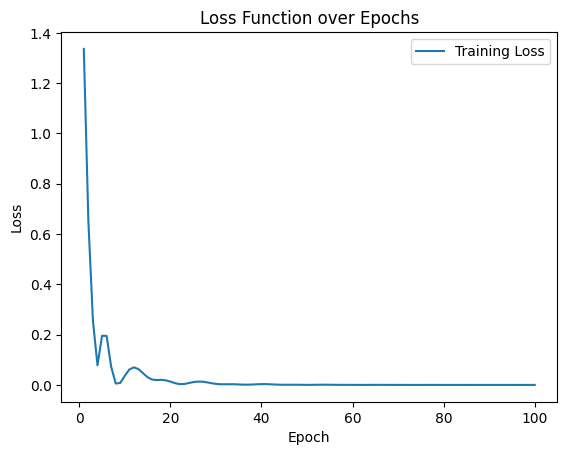

In [4]:
# %pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(range(1, 101), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Function over Epochs")
plt.legend()
plt.show()

In [68]:
interaction_matrix

tensor([[0.1051],
        [0.2559]])

In [5]:
grouped_events = recommended_events.groupby('userId')
for user_id, group in grouped_events:
    print(f"User: {user_id}")
    print(group)

User: 31de82ba-c5db-4c0a-9f77-61b6b7f7c92e
                                 userId  eventId                   eventName  \
0  31de82ba-c5db-4c0a-9f77-61b6b7f7c92e       24  CampusWithCMU (UPDATED!!!)   

      score  
0  0.958962  
User: 48a18dd9-48c3-45a5-b4f3-e8d7a60e2910
                                 userId  eventId                   eventName  \
0  48a18dd9-48c3-45a5-b4f3-e8d7a60e2910       24  CampusWithCMU (UPDATED!!!)   

      score  
0  0.875223  


In [6]:
torch.save(model.state_dict(), "ncf_model.pth")